In [12]:
import matlab.engine
eng = matlab.engine.start_matlab()

In [4]:
#import matlab.engine
import numpy as np;
from sklearn.neighbors import KDTree
import FactorBP as FB
from scipy.spatial import Delaunay
import scipy.io as sio
from Utils import *

def ComputeAccuracyPas(decode, gTruth, NofInliers ):
    Ccnt = 0
    for i in range(NofInliers):
        if(decode[i] == gTruth[i]):
            Ccnt += 1
    return 1.0 * Ccnt / NofInliers
# eng = matlab.engine.start_matlab()
CarData = LoadMotor()

NofAlgorithms = 8
AlgorithmNames=['Ours', 'BCA', 'BCA-MP', 'BCA-IPFP', 'HGM', 'RRWHM', 'TM', 'OursPW']
MaxNofOus = 20
MeanAcc = np.zeros([MaxNofOus + 1, NofAlgorithms ])
MeanRtime = np.zeros([MaxNofOus + 1, NofAlgorithms])
MeanObj = np.zeros([MaxNofOus + 1, NofAlgorithms])

np.random.seed(123456)
NofInstances = 20


for NofOus in range(0,MaxNofOus+1):
    Accuracy = np.zeros([NofAlgorithms, NofInstances])
    Rtime = np.zeros([NofAlgorithms, NofInstances])
    Obj = np.zeros([NofAlgorithms, NofInstances])
    for idx in range(1, NofInstances + 1):
        
        car1 = CarData[idx]
        LocalFeature1 = car1['features1']
        LocalFeature2 = car1['features2']
        
        PT1 = LocalFeature1[:, 0:2]
        PT2 = LocalFeature2[:, 0:2]
        
        
        orientation1 = LocalFeature1[:, 8]
        orientation2 = LocalFeature2[:, 8]
        
        GT = car1['gTruth'][0]
        
        NofInliers = len(GT)
        CMaxNofOus = np.min([LocalFeature1.shape[0], LocalFeature2.shape[0]]) - NofInliers
        CNofOus = NofOus
        if(CNofOus > CMaxNofOus):
            CNofOus = CMaxNofOus
        NofNodes = CNofOus + NofInliers
        gTruth = np.random.permutation(NofNodes)
        PT1 = PT1[gTruth, :]
        orientation1 = orientation1[gTruth]
        MG1 = FB.MatchingGraph(PT1[0:NofNodes], orientation1[0:NofNodes])
        MG2 = FB.MatchingGraph(PT2[0:NofNodes], orientation2[0:NofNodes])

        G = FB.ConstructMatchingModel(MG1, MG2, 'pas', True)
        G2 = FB.ConstructMatchingModel(MG1, MG2, 'pas', False)
        Gvis = FB.ConstructMatchingModel(MG1, MG2, 'pas', True)
        
        G.SetVerbose(False)
        
        res1 = FB.BaBSolver(G, 100, 10, 0.005, False)
        res2 = FB.BaBSolver(G2, 100, 10, 0.005, False)
        resBag = eng.runBcagm(nargout=3)
        resBagMP = eng.runBcagmQuad1(1,nargout=3)
        resBagIPFP = eng.runBcagmQuad1(2,nargout=3)
        resHGM = eng.runHGM(nargout=3)
        resRRWHM = eng.runRRWHM(nargout=3)
        resTM = eng.runTensorMatching(nargout=3)
        
        ImageI = idx - 1
        Accuracy[0][ImageI] = ComputeAccuracyPas(res1.Decode, gTruth, NofInliers)
        Rtime[0][ImageI] = res1.Time
        Obj[0][ImageI] = res1.Value
        
        Accuracy[7][ImageI] = ComputeAccuracyPas(res2.Decode, gTruth, NofInliers)
        Rtime[7][ImageI] = res2.Time
        Obj[7][ImageI] = res2.Value
        
        
        Accuracy[1][ImageI] = ComputeAccuracyPas(resBag[1][0], gTruth, NofInliers)
        Rtime[1][ImageI] = resBag[0]
        cDecode = FB.intArray(NofNodes)
        for i in range(NofNodes):
            cDecode[i] = int(resBag[1][0][i])
        Obj[1][ImageI] = Gvis.ComputeObj(cDecode)
        
        

        Accuracy[2][ImageI] = ComputeAccuracyPas(resBagMP[1][0], gTruth, NofInliers)
        Rtime[2][ImageI] = resBagMP[0]
        for i in range(NofNodes):
            cDecode[i] = int(resBagMP[1][0][i])
        Obj[2][ImageI] = Gvis.ComputeObj(cDecode)
        
        Accuracy[3][ImageI] = ComputeAccuracyPas(resBagIPFP[1][0], gTruth, NofInliers)
        Rtime[3][ImageI] = resBagIPFP[0]
        for i in range(NofNodes):
            cDecode[i] = int(resBagIPFP[1][0][i])
        Obj[3][ImageI] = Gvis.ComputeObj(cDecode)
        
        
        Accuracy[4][ImageI] = ComputeAccuracyPas(resHGM[1][0], gTruth, NofInliers)
        Rtime[4][ImageI] = resHGM[0]
        for i in range(NofNodes):
            cDecode[i] = int(resHGM[1][0][i])
        Obj[4][ImageI] = Gvis.ComputeObj(cDecode)
        
        
        Accuracy[5][ImageI] = ComputeAccuracyPas(resRRWHM[1][0], gTruth, NofInliers)
        Rtime[5][ImageI] = resRRWHM[0]
        for i in range(NofNodes):
            cDecode[i] = int(resRRWHM[1][0][i])
        Obj[5][ImageI] = Gvis.ComputeObj(cDecode)

        Accuracy[6][ImageI] = ComputeAccuracyPas(resTM[1][0], gTruth, NofInliers)
        Rtime[6][ImageI] = resTM[0]
        for i in range(NofNodes):
            cDecode[i] = int(resTM[1][0][i])
        Obj[6][ImageI] = Gvis.ComputeObj(cDecode)

        MaxObj = np.max(Obj[:,ImageI])
        Obj[:,ImageI] /= MaxObj

        #for ai in xrange(NofAlgorithms):
        #    print('%s Accuracy %f Running Time %f Obj %f' %(AlgorithmNames[ai], 
        #                                                     Accuracy[ai][ImageI],
        #                                                    Rtime[ai][ImageI],
        #                                                    Obj[ai][ImageI]))
        print('NofOus: %d, Finished Frame: %d' % (NofOus, ImageI))

    for ai in xrange(NofAlgorithms):
        MeanAcc[NofOus][ai] = np.mean(Accuracy[ai])
        MeanRtime[NofOus][ai] = np.mean(Rtime[ai])
        MeanObj[NofOus][ai] = np.mean(Obj[ai])
        print('%s Accuracy %f Running Time %f Obj %f' %(AlgorithmNames[ai], 
                                                        np.mean(Accuracy[ai]),
                                                        np.mean(Rtime[ai]),
                                                        np.mean(Obj[ai])))
        #G2.SetVerbose(False)
        #G1.Solve(400)
        #G2.Solve(400)
        #Accurancy[idx - 1] = ComputeAccuracyPas(G1.GetDecode(), gTruth, NofInliers)

        #print('%d %f %f' % (idx, ComputeAccuracyPas(G1.GetDecode(), gTruth, NofInliers),
        #                    ComputeAccuracyPas(G2.GetDecode(), gTruth, NofInliers)))
        #print(res.Time)
        #print(res.Value)

        #AccurancyPW[idx - 1] = ComputeAccuracyPas(G2.GetDecode(), gTruth, NofInliers)

        #print(ComputeAccuracyPas(resPW.Decode, NofInliers))
        #print(resPW.Time)
        #print(resPW.Value)
    #print('HyperAccurancy %f, PairwiseAccurancy %f' % (Accurancy.mean(), AccurancyPW.mean()))
    

NofOus: 0, Finished Frame: 0
NofOus: 0, Finished Frame: 1
NofOus: 0, Finished Frame: 2
NofOus: 0, Finished Frame: 3
NofOus: 0, Finished Frame: 4
NofOus: 0, Finished Frame: 5
NofOus: 0, Finished Frame: 6
NofOus: 0, Finished Frame: 7
NofOus: 0, Finished Frame: 8
NofOus: 0, Finished Frame: 9
NofOus: 0, Finished Frame: 10
NofOus: 0, Finished Frame: 11
NofOus: 0, Finished Frame: 12
NofOus: 0, Finished Frame: 13
NofOus: 0, Finished Frame: 14
NofOus: 0, Finished Frame: 15
NofOus: 0, Finished Frame: 16
NofOus: 0, Finished Frame: 17
NofOus: 0, Finished Frame: 18
NofOus: 0, Finished Frame: 19
Ours Accuracy 0.896086 Running Time 1.420674 Obj 0.998676
BCA Accuracy 0.610863 Running Time 0.040967 Obj 0.854289
BCA-MP Accuracy 0.692245 Running Time 0.288253 Obj 0.912594
BCA-IPFP Accuracy 0.682147 Running Time 0.148295 Obj 0.901927
HGM Accuracy 0.311747 Running Time 0.006910 Obj 0.393290
RRWHM Accuracy 0.682587 Running Time 0.792646 Obj 0.906845
TM Accuracy 0.581400 Running Time 0.071088 Obj 0.842635
O

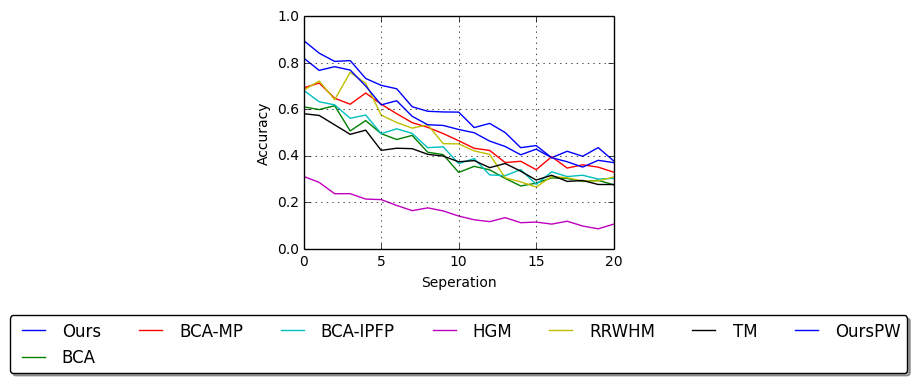

In [9]:
import matplotlib.pyplot as plt
import matplotlib
AlgorithmNames=['Ours', 'BCA', 'BCA-MP', 'BCA-IPFP', 'HGM', 'RRWHM', 'TM', 'OursPW']

#matplotlib.rc('font',family='Times New Roman')

%matplotlib inline

plt.figure(num=None, figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')

for ai in xrange(NofAlgorithms):
    plt.plot(range(0,MaxNofOus+1), MeanAcc[:,ai], label=AlgorithmNames[ai])
plt.ylim([0,1.0])
plt.grid(True)

plt.ylabel('Accuracy')
plt.xlabel('Seperation')

plt.legend(shadow=True, fancybox=True,loc='upper center', bbox_to_anchor=(0.5,-0.25), ncol=7)
plt.savefig('Motor_ACC.pdf')    # <-- loses transparency

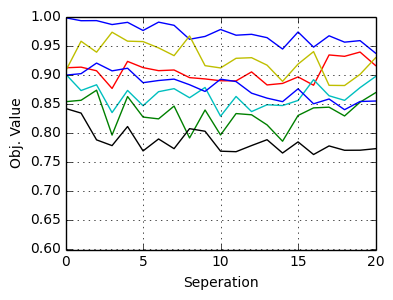

In [10]:
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline

%matplotlib inline
plt.figure(num=None, figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')


for ai in xrange(NofAlgorithms):
    plt.plot(range(0,MaxNofOus+1), MeanObj[:,ai], label=AlgorithmNames[ai])
plt.ylim([0.6,1])
plt.ylabel('Obj. Value')
plt.xlabel('Seperation')
plt.grid(True)
plt.savefig('Motor_Obj.pdf')    # <-- loses transparency

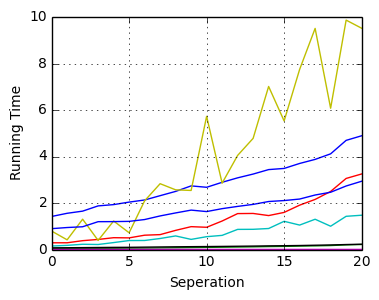

In [8]:
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
plt.figure(num=None, figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')


for ai in xrange(NofAlgorithms):
    plt.plot(range(0,MaxNofOus + 1), MeanRtime[:,ai], label=AlgorithmNames[ai])
plt.ylabel('Running Time')
plt.xlabel('Seperation')

plt.grid(True)
plt.savefig('Motor_Time.pdf')    # <-- loses transparency

In [11]:
import shelve



filename='shelve_motor.out'
my_shelf = shelve.open(filename,'n') # 'n' for new

for key in dir():
    try:
        my_shelf[key] = globals()[key]
    except TypeError:
        #
        # __builtins__, my_shelf, and imported modules can not be shelved.
        #
        print('ERROR shelving: {0}'.format(key))
my_shelf.close()

ERROR shelving: FB
ERROR shelving: G
ERROR shelving: G2
ERROR shelving: Gvis
ERROR shelving: __builtin__
ERROR shelving: __builtins__
ERROR shelving: _sh
ERROR shelving: cDecode


MatlabExecutionError: Undefined function or variable '__getstate__'.
